<a href="https://colab.research.google.com/github/yashagrawal5757/Wharton-Analytics-Fellows/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Approach to problem
* First load data and perform basic cleaning
* Make a baseline dirty model and check performance 
* Perform in depth EDA, Pre processing, Feature engineering
* Develop an improved model. See how this compares to our baseline model
* Once we have our model score, train a decision tree based on these scores and necessary features to find rules that can be recommended to bank managers

### Libraries import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn import tree



import xgboost
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


from statsmodels.stats.outliers_influence import variance_inflation_factor


C:\Users\yasha\AppData\Roaming\Python\Python38\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Dataset import

In [ ]:
data = pd.read_csv('sp23_datachallenge.csv')

In [ ]:
data.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [ ]:
data.shape

(1000000, 32)

### A million rows and 32 columns - 31 independent features

In [ ]:
data.fraud_bool.value_counts()


0    988971
1     11029
Name: fraud_bool, dtype: int64

In [ ]:
100 * data.fraud_bool.value_counts()[0]/(data.fraud_bool.value_counts()[0] + data.fraud_bool.value_counts()[1])
# 98.89 % rows have no fraud

98.8971

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [ ]:
data.isnull().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

### No null values present in any column. 

In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


### List  of categorical columns

In [ ]:
categorical_columns = list(data.select_dtypes(['object']))
categorical_columns

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

### One hot encoding

In [ ]:
data_encoded = pd.get_dummies(data, categorical_columns,drop_first=True)
len(data_encoded.columns)

48

#### 48 columns

### Train test splitting

In [ ]:
X = data_encoded.iloc[:,1:]
y = data_encoded.iloc[:,0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 42)

In [ ]:
print(X_train.shape, X_test.shape)

(700000, 47) (300000, 47)


### Baseline model - XGBoost

In [ ]:
xgb_baseline = XGBClassifier()
xgb_baseline.fit(X_train,y_train)
ypred_baseline = xgb_baseline.predict(X_test)


C:\Users\yasha\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\yasha\AppData\Roaming\Python\Python38\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[02:41:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
cm_baseline = confusion_matrix(ypred_baseline,y_test)

In [ ]:
cm_baseline

array([[296483,   3217],
       [   150,    150]], dtype=int64)

### ROC Curve/ROC AUC score

In [ ]:
roc_auc_baseline = roc_auc_score(y_test, xgb_baseline.predict_proba(X_test)[:, 1])

In [ ]:
roc_auc_baseline

0.8893946410692692

## <div class="alert alert-block alert-warning"> We get an ROC AUC score of 0.89 which is good. We will try to improve on it

C:\Users\yasha\AppData\Roaming\Python\Python38\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Text(0, 0.5, 'True Positive Rate')

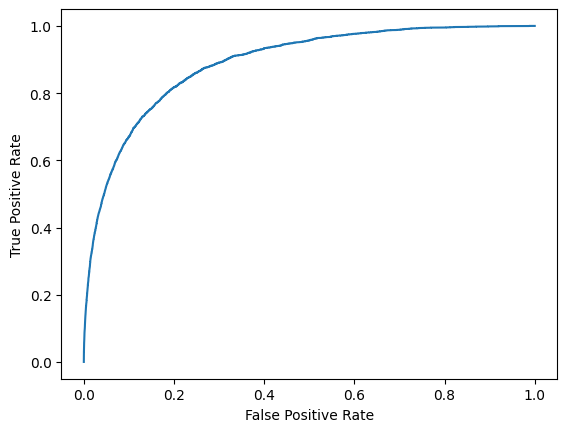

In [ ]:
fpr_baseline, tpr_baseline, thresholds_baseline = metrics.roc_curve(y_test, xgb_baseline.predict_proba(X_test)[:, 1])
plt.plot(fpr_baseline, tpr_baseline)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## <div class="alert alert-block alert-warning">  We got a good baseline auc score and a good ROC Curve as well.

### Now we will do multiple cleaning, eda, visualization, feature engineering steps and will try to improve our AP score and better our precision recall curve

#### Heatmap

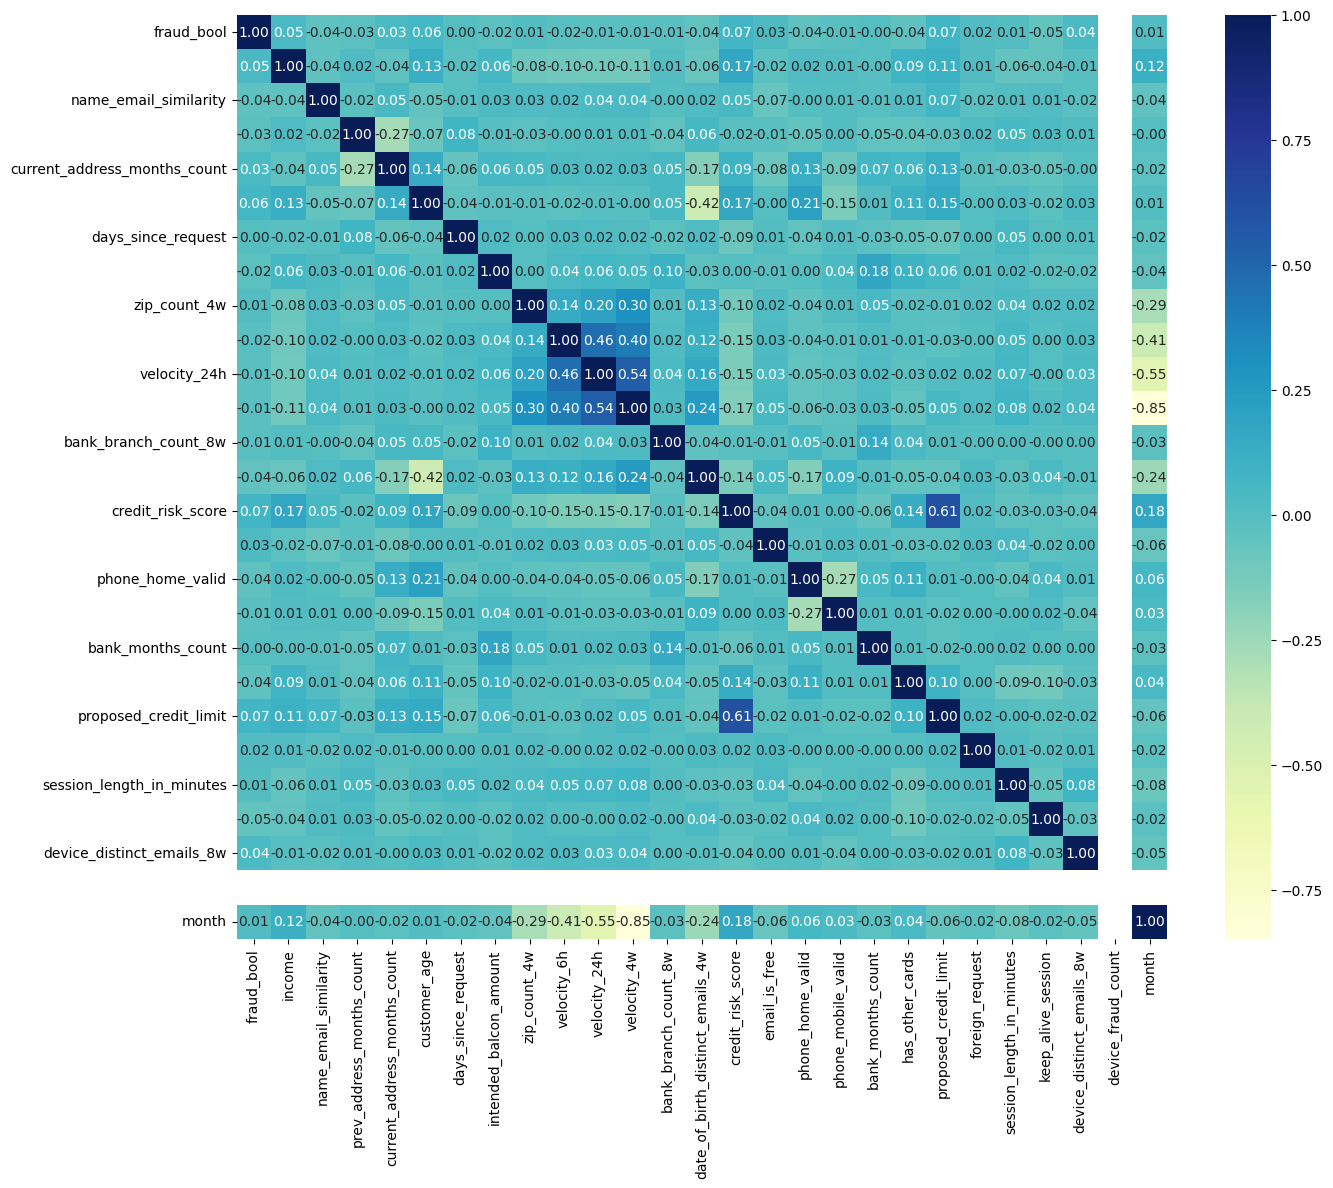

In [ ]:
#plt.figure(figsize = (12,12))
sns.heatmap(data.corr(),cmap = 'YlGnBu',annot=True,cbar=True, fmt='.2f')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


In [ ]:
### There are some columns where there are -1 or negative values. Lets see which columns are these
# previous address count - This doesnt have zero
# current address count - This has 0 as well
# intended_balcon_amount - have negative values
# velocity_6h - has negative values
# credit risk score - negatived
# session_length_in_minutes - negative values
# device_distinct_emails_8w - negative values

In [ ]:
len(data[data['current_address_months_count'] == 0])  #9609 
len(data[data['current_address_months_count'] == -1]) #4254

4254

### Handling negative values in each column

* 1. prev_address_months_count : -1 converted to 0
* 2. current_address_months_count : -1 converted to 0

#### Since people who have recently moved in have marked 0, -1 means that data is missing. Since there is a large number of data missing, we will let it be -1. 
#### I also plan to create a feature that adds total months of stay in current as well as old address. So having a -1 doesnt make sense in summation, we will add +1 to avoid summation with -1 then

In [ ]:
copy = data.copy()

In [ ]:
data = copy.copy()

* 3. intended_balcon_amount -  No change

#### Negative values here might be for the cases where banks give line of credit/loans to new users on the basis of their credit history. So the first transaction/opening balance can be negative also. But highest value is 113. It seems like this feature has been scaled down and should be treated accordingly

* velocity_6h : Multiply by -1

In [ ]:
#checking negative velocity rows - 44 rows
data[data['velocity_6h']<0]['velocity_6h']
# There is a high chance that its a data entry error and signs have been inverted
data['velocity_6h'].iloc[data[data['velocity_6h']<0].index] = data['velocity_6h'].iloc[data[data['velocity_6h']<0].index] * -1


C:\Users\yasha\AppData\Local\Temp\ipykernel_33348\233313345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['velocity_6h'].iloc[data[data['velocity_6h']<0].index] = data['velocity_6h'].iloc[data[data['velocity_6h']<0].index] * -1


* credit risk score - no change

#### Generally credit scores are in range 0-1000. But this is some internal scores where both lower and upper bounds are different. So I am not changing it

* bank_months_count - no change
#### -1 means missing here. We dont have info about large proportion of people if they had an old bank account or not. We can keep it -1/missing = yes anything. It serves the same purpose to model

* session_length_in_minutes - make it zero
### this should generally not be negative

In [ ]:
data['session_length_in_minutes'].loc[data[data['session_length_in_minutes'] < 0].index] = 0

C:\Users\yasha\AppData\Local\Temp\ipykernel_33348\2546157030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['session_length_in_minutes'].loc[data[data['session_length_in_minutes'] < 0].index] = 0


* device_distinct_emails_8w - change to zero
#### device_distinct_emails_8w - no of emails cant be negative. The range given in excel is also starting from 0

In [ ]:
data['device_distinct_emails_8w'].loc[data[data['device_distinct_emails_8w'] < 0].index] = 0

C:\Users\yasha\AppData\Local\Temp\ipykernel_33348\959534160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['device_distinct_emails_8w'].loc[data[data['device_distinct_emails_8w'] < 0].index] = 0


# <div class="alert alert-block alert-success"> Univariate Analysis, Multivariate Analysis - EDA

In [ ]:
fraud_data = data[data['fraud_bool'] == 1]
nonfraud_data = data[data['fraud_bool'] == 0]

### <div class="alert alert-block alert-info"> Income analysis

Text(0, 0.5, 'Income')

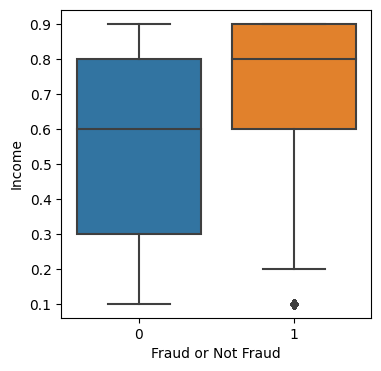

In [ ]:
plt.figure(figsize = (4,4))
sns.boxplot(data = data,y ='income',x='fraud_bool')
plt.xlabel("Fraud or Not Fraud")
plt.ylabel("Income")


### <div class="alert alert-block alert-warning"> The average income of fraudulent applications are higher than non fraudulent applications

### Derived Feature - income_category
* Bucket1 = 0th-25th quantile
* Bucket2 = 25th-75th quantile
* Bucket3 = 75th-100th quantile

In [ ]:
data['income_category'] = pd.qcut(data['income'], q=[0, .25, .75, 1], labels=['low', 'medium', 'high'])

#### Now lets see proportion of fraud across different income groups

<AxesSubplot: xlabel='fraud_bool', ylabel='count'>

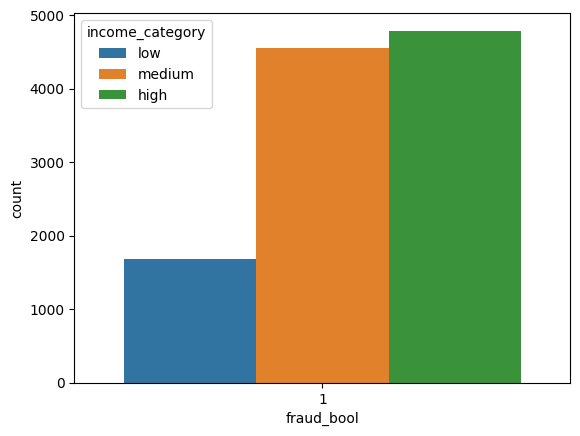

In [ ]:
sns.countplot(data[data['fraud_bool'] == 1], x= 'fraud_bool',hue = 'income_category')

### <div class="alert alert-block alert-warning"> There are more fraud cases occuring in medium and high income groups rather than low income groups 

### <div class="alert alert-block alert-info"> Address count analysis

In [ ]:
#sns.boxplot(data, y='current_address_months_count',x='fraud_bool')

###  derived feature - address counts : if a person has lived for long in their current home or they lived long in their last home and have recently moved in, it shows stability. We can segment them into category accordingly

In [ ]:
data['address_counts']  = data['prev_address_months_count'] + data['current_address_months_count'] +2 # to address -1 issue

### derived feature - address count category
* Bucket1 = 0th-25th quantile
* Bucket2 = 25th-75th quantile
* Bucket3 = 75th-100th quantile

In [ ]:
data['address_stability'] = pd.qcut(data['address_counts'], q=[0, .25, .75, 1], labels=['low', 'medium', 'high'])

In [ ]:
data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,income_category,address_counts,address_stability
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,INTERNET,3.888115,windows,0,1,0,7,high,89,medium
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,INTERNET,31.798819,windows,0,1,0,7,high,145,medium
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,INTERNET,4.728705,other,0,1,0,7,high,133,medium
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,INTERNET,2.047904,linux,0,1,0,7,high,23,low
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,INTERNET,3.775225,macintosh,1,1,0,7,high,219,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,INTERNET,8.511502,linux,1,1,0,4,medium,105,medium
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,INTERNET,8.967865,windows,0,1,0,4,medium,159,high
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,INTERNET,8.195531,other,0,1,0,4,medium,31,low
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,INTERNET,4.336064,windows,1,1,0,4,high,190,high


### Now lets see proportion of fraud across different address count category groups¶

<AxesSubplot: xlabel='fraud_bool', ylabel='count'>

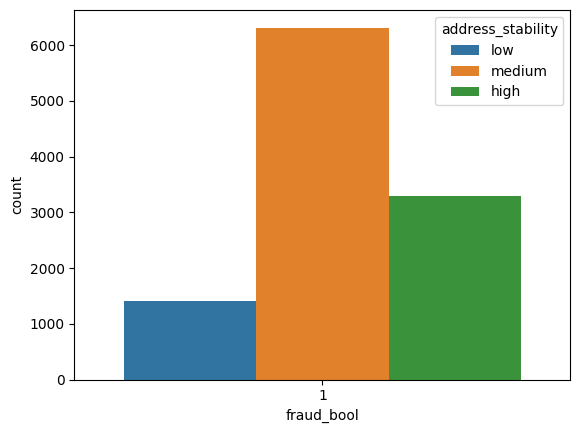

In [ ]:
sns.countplot(data[data['fraud_bool'] == 1], x= 'fraud_bool',hue = 'address_stability')

### <div class="alert alert-block alert-warning"> Fraudsters tend to show atleast some stable housing history. This shows they have taken necessary steps to conceal their fraudulent activities and create a false sense of trust or legitimacy. 

<br>

### <div class="alert alert-block alert-info">  Age analysis

#### No. of fraud cases across different age groups

Text(0.5, 1.0, 'Fraud count across different age buckets')

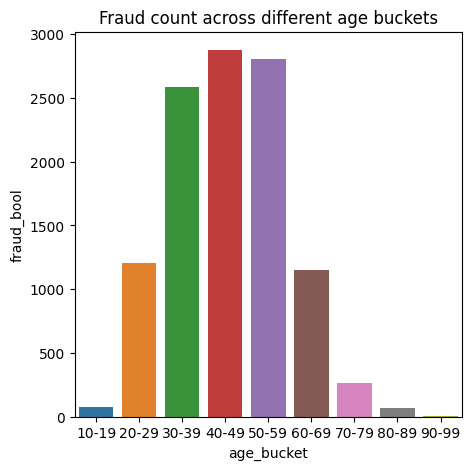

In [ ]:
age_fraud = data.groupby('customer_age')['fraud_bool'].sum().reset_index()
age_fraud
age_fraud['age_bucket'] = ['10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

plt.figure(figsize = (5,5))
sns.barplot(data =age_fraud , y = 'fraud_bool',x = 'age_bucket')
plt.title("Fraud count across different age buckets")


### <div class="alert alert-block alert-warning"> Looks like people aged 20-59 have most fraud occurences. But the number of rows for these age groups are also high. So is this picture real ?
#### Lets find out proportion between fraud and non fraud applications 

#### Lets find out fraud proportion for different age groups (for each age bucket, calculate no of fraud applcns/total no of applications)

Text(0.5, 1.0, 'Fraud rate across different age buckets')

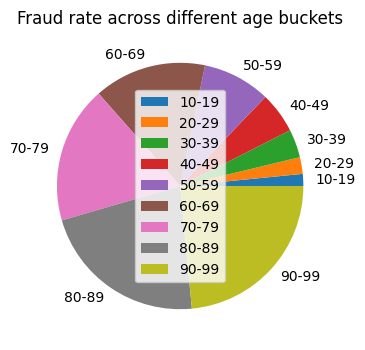

In [ ]:
age_fraud = 100*(data.groupby('customer_age')['fraud_bool'].sum()/data.groupby('customer_age')['fraud_bool'].count()).reset_index()
age_fraud['customer_age'] = age_fraud['customer_age']/100
age_fraud['age_bucket'] = ['10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']
age_fraud.drop('customer_age',axis=1)

plt.figure(figsize = (4,4))
plt.pie(age_fraud['fraud_bool'],labels = age_fraud['age_bucket'])
plt.legend(loc = 'center')
plt.title("Fraud rate across different age buckets")

## <div class="alert alert-block alert-warning"> <i> The proportion of fraud applications against non fraud applications is higher for elderly people . Thus we can say that in reality out of all applications, there are much higher chances of fraud for elderly people. This is because they are less tech savvy, and are more prone to being victims of stolen identity<i>

In [ ]:
age_fraud_rate = 100*data.groupby('customer_age')['fraud_bool'].mean().reset_index()
age_fraud_rate['customer_age'] = age_fraud_rate['customer_age']/100
age_fraud_rate.columns = ['customer_age','fraud rate in percentage']
age_fraud_rate

,customer_age,fraud rate in percentage
0,10.0,0.352599
1,20.0,0.490126
2,30.0,0.831318
3,40.0,1.204799
4,50.0,1.998532
5,60.0,3.304573
6,70.0,4.035599
7,80.0,4.934464
8,90.0,5.263158


### <div class="alert alert-block alert-warning"> Fraud rate increases as age increases

#### We saw from pie chart that people aged 60 or above have good proportion of fraud cases. Lets see if such wealthy elderly people are more prone to doing fraud?

In [ ]:
old_age_data = data[data['customer_age'] > 59]  #42660
#old_age_data['fraud_bool'].value_counts()
old_age_data['income'].describe()  #75th percentile is 0.8
old_age_data[old_age_data['income']>0.8]['fraud_bool'].value_counts()

# 6.7% chances

0    9089
1     612
Name: fraud_bool, dtype: int64

### <div class="alert alert-block alert-warning"> <i> People who are aged 60 or above and they earn in top 25% of this age bucket, have 7% chances of getting defrauded <i>

#### Lets see if they use website or app to send the application

In [ ]:
old_age_data['source'].value_counts()

INTERNET    42062
TELEAPP       598
Name: source, dtype: int64

### <div class="alert alert-block alert-warning"> 98.5% people who are aged 60 or above use website browsers to submit applications. But on further investigation no specific fraud trend found

### <div class="alert alert-block alert-warning"> Conclusion -  <i> Fraud rate increases as customer's age increases. People who are aged 60 or above and they earn in top 25% of this age bucket, have 7% chances of getting defrauded <i>

###  <div class="alert alert-block alert-info"> intended_balcon_amount analysis

In [ ]:
data.intended_balcon_amount.describe()

count    1000000.000000
mean           8.661499
std           20.236155
min          -15.530555
25%           -1.181488
50%           -0.830507
75%            4.984176
max          112.956928
Name: intended_balcon_amount, dtype: float64

**We see the value ranges between -15 to 112. Firstly can the values be negative? Yes since there are cases where banks give line of credit/loans to new users on the basis of their credit history. So the first transaction can be negative also. But highest value is 108. It seems like this feature has been scaled down and should be treated accordingly.**

### Derived Feature - line_of_credit = 1 if intended_balcon_amount<0 else 0

In [ ]:
data['line_of_credit'] = np.where(data['intended_balcon_amount']<0,1,0)

### People with low income but high balcon amount could potentially be a red flag as they might look to open an account to deposit illegal money

#### Lets study relationship of intended balcon amount + income against fraud


Text(0.5, 1.0, 'Income of Fraudsters who have high initial transfer amount')

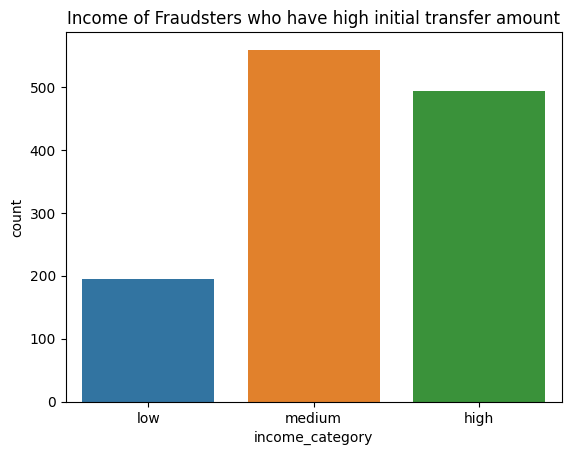

In [ ]:
high_initial_transfer = data[data['intended_balcon_amount']>4.9]  #people with high initial transfer (above 75th percentile)
sns.countplot(high_initial_transfer[high_initial_transfer['fraud_bool'] == 1], x='income_category')
plt.title("Income of Fraudsters who have high initial transfer amount")


### Surprisingly, we didn't observe the expected behavior

###  <div class="alert alert-block alert-info"> Payment plan analysis

#### Lets see distribution of payment plans across fraudulent data

<AxesSubplot: xlabel='payment_type', ylabel='count'>

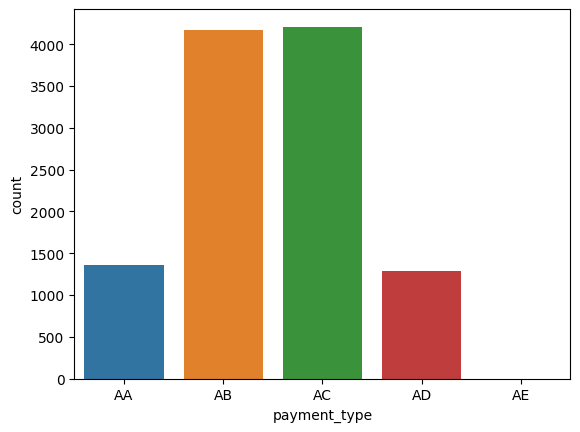

In [ ]:
sns.countplot(data = fraud_data, x = 'payment_type')

### Trend - > AB = AC > AA = AD > AE

In [ ]:
data['payment_type'].value_counts()

AB    370554
AA    258249
AC    252071
AD    118837
AE       289
Name: payment_type, dtype: int64

In [ ]:
fraud_data['payment_type'].value_counts()

AC    4209
AB    4169
AA    1364
AD    1286
AE       1
Name: payment_type, dtype: int64

### For group AE, only 1 fraudulent row is present

#### For fraudulent data,are there any prevalent payment  plans and  income group?

In [ ]:
fraud_data = data[data.fraud_bool == 1]
income_payment_data = fraud_data.groupby('payment_type')['income_category'].value_counts()
prop = pd.DataFrame(income_payment_data.groupby(level=0).apply(lambda x: 100*x / x.sum()))
prop.columns = ['Income category proportion for fraud applications']
prop

Income category proportion for fraud applications
payment_type                                                          
AA           medium                                          44.354839
             high                                            40.102639
             low                                             15.542522
AB           medium                                          42.384265
             high                                            42.024466
             low                                             15.591269
AC           high                                            44.666191
             medium                                          39.676883
             low                                             15.656926
AD           high                                            47.589425
             medium                                          39.657854
             low                                             12.752722
AE           medium                                         100.000000
             low                                              0.000000
             high                                             0.000000

 
#### <div class="alert alert-block alert-warning"> <i> For plan AE, we see that all the attacks come from medium income category i.e bands [0.3- 0.8] <i> . But this is not a trend as there was only 1 fraudulent row.

#### <div class="alert alert-block alert-warning"> <i> For rest of the group, medium and high income applicants have much more chances to be fraud than low income applicants
    
### <div class="alert alert-block alert-warning"> Conclusion - No specific income group in a payment plan depict a high chance of fraud
    

#### lets test the same thing with address stability

In [ ]:
data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,income_category,address_counts,address_stability,line_of_credit
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,3.888115,windows,0,1,0,7,high,89,medium,1
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,31.798819,windows,0,1,0,7,high,145,medium,1
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,4.728705,other,0,1,0,7,high,133,medium,1
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,2.047904,linux,0,1,0,7,high,23,low,1
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,3.775225,macintosh,1,1,0,7,high,219,high,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,8.511502,linux,1,1,0,4,medium,105,medium,1
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,8.967865,windows,0,1,0,4,medium,159,high,1
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,8.195531,other,0,1,0,4,medium,31,low,0
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,4.336064,windows,1,1,0,4,high,190,high,0


In [ ]:
fraud_data = data[data['fraud_bool'] == 1]
address_payment_data = fraud_data.groupby('payment_type')['address_stability'].value_counts()
prop = pd.DataFrame(address_payment_data.groupby(level=0).apply(lambda x: 100*x / x.sum()))
prop.columns = ['Address stability proportion for fraud applications']
prop

Address stability proportion for fraud applications
payment_type                                                            
AA           medium                                          54.618768  
             high                                            34.237537  
             low                                             11.143695  
AB           medium                                          56.752219  
             high                                            29.239626  
             low                                             14.008155  
AC           medium                                          59.729152  
             high                                            29.674507  
             low                                             10.596341  
AD           medium                                          53.576983  
             high                                            28.538103  
             low                                             17.884914  
AE           medium                                         100.000000  
             low                                              0.000000  
             high                                             0.000000

#### This is in accordance to bar plot plotted earlier which told medium address history were more prevelant to fraud. We see the same trend here

###  <div class="alert alert-block alert-info"> Velocity variables analysis

### We have month variable. Lets find out average velocity (6h,24h,4w) for each month. And see for rows where veloctiy was greater than mean, did the fraud increase?

In [ ]:
data.groupby(['month'])[['velocity_6h','velocity_24h','velocity_4w']].mean()

,velocity_6h,velocity_24h,velocity_4w
month,,,
0,7436.980252,5882.409562,6189.182587
1,6821.410562,5544.745790,5392.224047
2,6465.411620,5293.535446,5356.302289
3,5960.159875,4972.625369,4913.600261
4,5323.336783,4612.584795,4640.167688
5,4755.852532,4218.687532,4284.615735
6,3958.620644,3691.506701,4119.226042
7,3605.332789,3260.626953,3343.593679


In [ ]:
data.groupby(['month','fraud_bool'])[['velocity_6h','velocity_24h','velocity_4w']].mean()

velocity_6h  velocity_24h  velocity_4w
month fraud_bool                                        
0     0           7442.277856   5884.259339  6189.511794
      1           6974.534773   5720.936308  6160.445066
1     0           6825.967872   5545.780318  5392.516048
      1           6340.488886   5435.574625  5361.409875
2     0           6465.960615   5294.172807  5356.412009
      1           6403.188650   5221.297088  5343.866687
3     0           5964.847084   4972.911687  4913.430241
      1           5456.608193   4941.865945  4931.865721
4     0           5328.127043   4613.535216  4639.951663
      1           4906.864520   4529.953807  4658.949159
5     0           4759.052383   4218.072737  4284.783695
      1           4488.452904   4270.063663  4270.579966
6     0           3960.548823   3691.237888  4119.513725
      1           3816.709327   3711.290967  4098.052961
7     0           3608.388527   3260.513830  3343.446444
      1           3401.156913   3268.185558  3353.431517

### <div class="alert alert-block alert-warning">There is a clear pattern that for each month, whenever mean velocity at any time is lower, there is a higher chance of application being fraud than non fraud. This is quite surprising as one would expect the fraudsters to use times of heavy traffic to infiltrate the system.

### Derived Feature - velocity_6h_risky,velocity_24h_risky,velocity_4w_risky : for each row, given the month that row belongs to, if the average velocity is less than mean velocity for the month, flag it 1 else 0 

In [ ]:
monthly_mean_velocity = data.groupby(['month'])[['velocity_6h','velocity_24h','velocity_4w']].mean().reset_index()
monthly_mean_velocity.columns = ['month', 'mean_velocity_6h', 'mean_velocity_24h', 'mean_velocity_4w']
monthly_mean_velocity

,month,mean_velocity_6h,mean_velocity_24h,mean_velocity_4w
0,0,7436.980252,5882.409562,6189.182587
1,1,6821.410562,5544.745790,5392.224047
2,2,6465.411620,5293.535446,5356.302289
3,3,5960.159875,4972.625369,4913.600261
4,4,5323.336783,4612.584795,4640.167688
5,5,4755.852532,4218.687532,4284.615735
6,6,3958.620644,3691.506701,4119.226042
7,7,3605.332789,3260.626953,3343.593679


In [ ]:
# create dictionary for all 3 variables:
dict_velocity_6h = monthly_mean_velocity['mean_velocity_6h'].to_dict()
dict_velocity_24h = monthly_mean_velocity['mean_velocity_24h'].to_dict()
dict_velocity_4w = monthly_mean_velocity['mean_velocity_4w'].to_dict()


In [ ]:
data['velocity_6h_risky'] = ""
data['velocity_24h_risky'] = ""
data['velocity_4w_risky'] = ""
data['velocity_6h_risky'] = data.apply(lambda row: 1 if row['velocity_6h'] < dict_velocity_6h[row['month']] else 0, axis=1)
data['velocity_24h_risky'] = data.apply(lambda row: 1 if row['velocity_24h'] < dict_velocity_24h[row['month']] else 0, axis=1)
data['velocity_4w_risky'] = data.apply(lambda row: 1 if row['velocity_4w'] < dict_velocity_4w[row['month']] else 0, axis=1)

        
       

#### Lets see if this derived feature is able to capture frauds or not

In [ ]:
print("Fraud Capture rate using 6hr traffic : ", 100 * data[data['velocity_6h_risky'] ==1][data[data['velocity_6h_risky'] ==1]['fraud_bool'] == 1].shape[0] / 11029) # 11029 is total fraud cases
print("Fraud Capture rate using 24hr traffic: ", 100 * data[data['velocity_24h_risky'] ==1][data[data['velocity_24h_risky'] ==1]['fraud_bool'] == 1].shape[0] / 11029) # 11029 is total fraud cases
print("Fraud Capture rate using 4w traffic  : ", 100 * data[data['velocity_4w_risky'] ==1][data[data['velocity_4w_risky'] ==1]['fraud_bool'] == 1].shape[0] / 11029) # 11029 is total fraud cases

Fraud Capture rate using 6hr traffic :  56.06129295493698
Fraud Capture rate using 24hr traffic:  55.39033457249071
Fraud Capture rate using 4w traffic  :  52.452624897996195


### <div class="alert alert-block alert-warning"> This is pretty good. These features capture more than 50 % of fraudulent cases

### <div class="alert alert-block alert-info"> employment_status analysis 

Text(0.5, 1.0, 'Number of fraud occurences in eacch employment group')

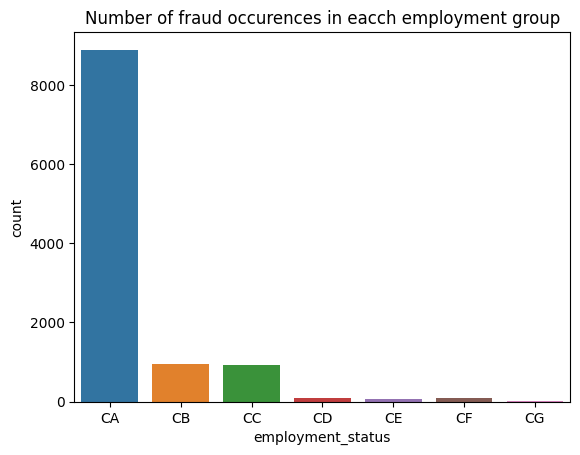

In [ ]:
sns.countplot(fraud_data, x = 'employment_status')
plt.title("Number of fraud occurences in eacch employment group")

In [ ]:
data.groupby('employment_status')['fraud_bool'].mean()* 100

employment_status
CA    1.218620
CB    0.689142
CC    2.468351
CD    0.377045
CE    0.233552
CF    0.193033
CG    1.545254
Name: fraud_bool, dtype: float64

### It seemed like all frauds were occuring in group CA. But the proportion says otherwise. Group CA, CC, CG are equally likely to be fraudulent. Lets do label encoding based on fraud rate

In [ ]:
employment_rank = pd.DataFrame(data.groupby('employment_status')['fraud_bool'].mean()).sort_values(by = 'fraud_bool',ascending = False)
employment_rank
employment_rank_dict = employment_rank.to_dict()['fraud_bool']
data['employment_status_encoded'] = data.apply(lambda row : employment_rank_dict[row['employment_status']],axis = 1)

### <div class="alert alert-block alert-info"> credit_risk_score analysis


#### What is the average credit score for fraud vs non fraud

In [ ]:
data['credit_risk_score'].describe()
# -170 to 389

count    1000000.000000
mean         130.989595
std           69.681812
min         -170.000000
25%           83.000000
50%          122.000000
75%          178.000000
max          389.000000
Name: credit_risk_score, dtype: float64

<AxesSubplot: xlabel='fraud_bool', ylabel='credit_risk_score'>

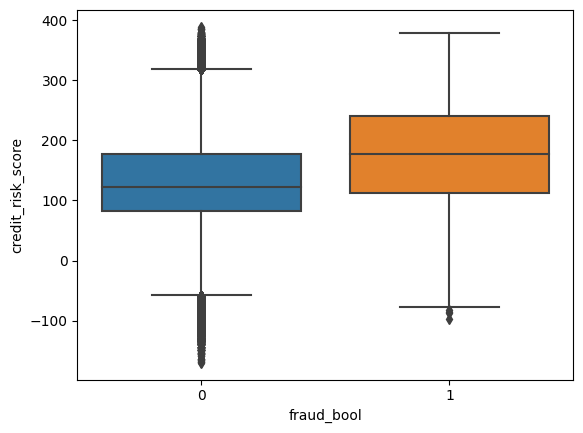

In [ ]:
sns.boxplot(y = data['credit_risk_score'],x = data['fraud_bool'])

### There are a lot of outliers. But since no info has been given as to why the values can be negative. We cant estimate the cause of these outliers. It can be the case that the values have been scaled down. Lets keep the outliers

### <div class="alert alert-block alert-warning"> credit risk scores are higher for fraud cases

In [ ]:
data.corr()['credit_risk_score'].sort_values()

velocity_4w                        -0.168766
velocity_24h                       -0.146770
velocity_6h                        -0.145253
date_of_birth_distinct_emails_4w   -0.137338
zip_count_4w                       -0.102645
days_since_request                 -0.088141
bank_months_count                  -0.061105
device_distinct_emails_8w          -0.041677
email_is_free                      -0.036274
session_length_in_minutes          -0.034480
keep_alive_session                 -0.031135
prev_address_months_count          -0.016104
bank_branch_count_8w               -0.014569
intended_balcon_amount              0.002058
phone_mobile_valid                  0.004166
phone_home_valid                    0.005256
foreign_request                     0.016265
name_email_similarity               0.049126
velocity_24h_risky                  0.052712
velocity_6h_risky                   0.064033
line_of_credit                      0.069360
fraud_bool                          0.070624
velocity_4

### People having high  credit score risk, and asking for high credit limit can be suspicious. Lets see that

<AxesSubplot: xlabel='credit_risk_score', ylabel='proposed_credit_limit'>

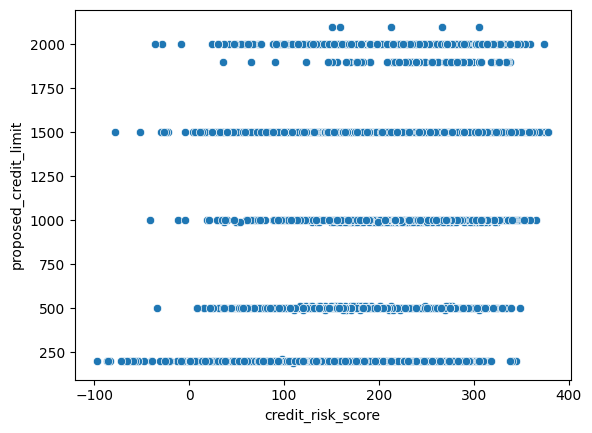

In [ ]:
sns.scatterplot(fraud_data, x = 'credit_risk_score', y ='proposed_credit_limit')

#### No fixed trend that high credit risk score and high proposed credit limit necessitates fraud

### Derived Feature : credit_risk_category

In [ ]:
data['credit_risk_category'] = pd.qcut(data['credit_risk_score'], q=[0, .25, .75, 1], labels=['low', 'medium', 'high'])

### Derived Feature - difference between mean credit score and current credit score

In [ ]:
data['credit_risk_score'].mean()


130.989595

In [ ]:
data['credit_risk_score'].mean()
data['credit_risk_score_delta'] = (data['credit_risk_score'] - data['credit_risk_score'].mean())/ data['credit_risk_score'].std()


### <div class="alert alert-block alert-info"> email_is_free analysis


<AxesSubplot: xlabel='email_is_free', ylabel='count'>

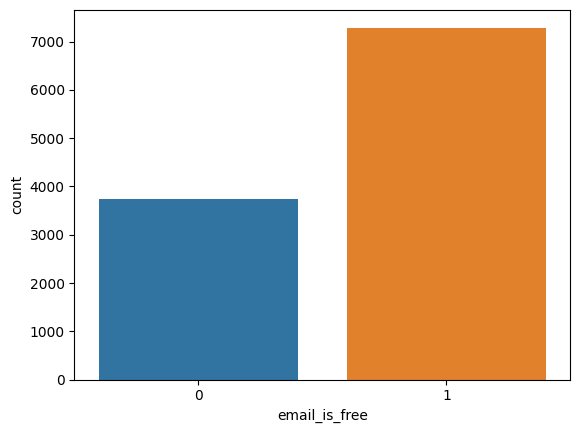

In [ ]:
sns.countplot(x = fraud_data['email_is_free'])

### <div class="alert alert-block alert-info"> housing_status analysis


### Lets find total proportion of fraud/total rows for each housing category

In [ ]:
housing_rank = pd.DataFrame(data.groupby('housing_status')['fraud_bool'].mean()).sort_values(by = 'fraud_bool',ascending = False)
housing_rank

,fraud_bool
housing_status,
BA,0.037466
BD,0.008639
BC,0.006148
BB,0.006008
BF,0.004194
BG,0.003968
BE,0.003441


### <div class="alert alert-block alert-warning"> Chances of fraud - BA>BD>BC>BB>BF>BF>BE
### Do label encoding - replace housing categories by fraud rate

In [ ]:
housing_rank_dict = housing_rank.to_dict()['fraud_bool']
data['housing_status_encoded'] = data.apply(lambda row : housing_rank_dict[row['housing_status']],axis = 1)

###  <div class="alert alert-block alert-info">phone_home_valid, phone_mobile_valid analysis 

In [ ]:
data['phone_home_valid'].value_counts()  #nearly equal split

0    582923
1    417077
Name: phone_home_valid, dtype: int64

In [ ]:
data.groupby('phone_home_valid')['fraud_bool'].value_counts()

phone_home_valid  fraud_bool
0                 0             574685
                  1               8238
1                 0             414286
                  1               2791
Name: fraud_bool, dtype: int64

In [ ]:
#who dont give and fraud
823800/(8238+574685)

1.4132226726342931

In [ ]:
#who give but fraud
279100/(2791+414286)

0.6691809905604961

### <div class="alert alert-block alert-warning"> People who dont provide valid home number have slightly higher chances of fraud

In [ ]:
data['phone_mobile_valid'].value_counts()  #most of the people provide a valid phone number while opening account

1    889676
0    110324
Name: phone_mobile_valid, dtype: int64

In [ ]:
data.groupby('phone_mobile_valid')['fraud_bool'].value_counts()

phone_mobile_valid  fraud_bool
0                   0             108676
                    1               1648
1                   0             880295
                    1               9381
Name: fraud_bool, dtype: int64

In [ ]:
164800/(1648+108676)

1.4937819513433162

In [ ]:
938100/(9381+880295)

1.0544288032946825

### Whats the fraud proportion for people who dont give either contacts?


In [ ]:
no_numbers = data[(data['phone_mobile_valid'] ==0) & (data['phone_home_valid'] ==0)] # 20% of customers provide neither
no_numbers['fraud_bool'].value_counts()

0    21613
1      619
Name: fraud_bool, dtype: int64

In [ ]:
61900/(619+21613)

2.7842749190356244

### <div class="alert alert-block alert-warning"> The proportion of fraud increases form 1.4% -> 2.7% if both the numbers are not provided. Lets create a derived feature : no_number_provided

In [ ]:
data['no_number_provided'] = 1
data['no_number_provided'].iloc[data[(data['phone_mobile_valid'] ==0) & (data['phone_home_valid'] ==0)].index] = 0

C:\Users\yasha\AppData\Local\Temp\ipykernel_49236\701471256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['no_number_provided'].iloc[data[(data['phone_mobile_valid'] ==0) & (data['phone_home_valid'] ==0)].index] = 0


In [ ]:
data.corr()['no_number_provided'].sort_values()

housing_status_encoded             -0.028619
fraud_bool                         -0.024276
velocity_24h                       -0.024034
line_of_credit                     -0.022372
velocity_4w                        -0.021226
device_distinct_emails_8w          -0.019079
prev_address_months_count          -0.014848
proposed_credit_limit              -0.014431
customer_age                       -0.013245
velocity_6h                        -0.013092
days_since_request                 -0.012390
address_counts                     -0.012086
session_length_in_minutes          -0.011721
employment_status_encoded          -0.004999
current_address_months_count       -0.004552
foreign_request                    -0.001852
credit_risk_score_delta            -0.001801
credit_risk_score                  -0.001801
velocity_6h_risky                  -0.001528
zip_count_4w                       -0.001234
date_of_birth_distinct_emails_4w    0.003361
income                              0.004370
bank_branc

### <div class="alert alert-block alert-info"> bank_months_count analysis


### For all fraud applications, see what's the average duration fraudsters tend to keep old accounts, before opening a new account?

In [ ]:
fraud_data.bank_months_count.mean()

10.469580197660713

In [ ]:
data.bank_months_count.mean()

10.839303

###  <div class="alert alert-block alert-info"> has_other_cards analysis


In [ ]:
data.has_other_cards.value_counts()  ## Most of the people dont have other cards from the banking company

0    777012
1    222988
Name: has_other_cards, dtype: int64

In [ ]:
data.groupby('has_other_cards').fraud_bool.value_counts()

has_other_cards  fraud_bool
0                0             766914
                 1              10098
1                0             222057
                 1                931
Name: fraud_bool, dtype: int64

In [ ]:
1009800/(10098+766914)

1.2995938286667388

In [ ]:
data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,address_stability,line_of_credit,velocity_6h_risky,velocity_24h_risky,velocity_4w_risky,employment_status_encoded,credit_risk_category,credit_risk_score_delta,housing_status_encoded,no_number_provided
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,medium,1,0,1,0,0.012186,high,0.775100,0.037466,1
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,medium,1,1,1,1,0.012186,high,1.837071,0.037466,0
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,medium,1,0,1,1,0.006891,medium,0.660293,0.037466,1
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,low,1,1,0,1,0.012186,medium,-0.301221,0.037466,1
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,high,1,0,1,1,0.012186,high,2.353705,0.037466,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,medium,1,0,0,0,0.012186,low,-0.803504,0.006148,1
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,high,1,0,0,0,0.024684,medium,0.330221,0.006148,1
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,low,0,0,0,1,0.001930,low,-0.961364,0.006148,1
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,high,0,0,1,1,0.012186,medium,0.459380,0.037466,1


### <div class="alert alert-block alert-warning"> Higher chance of fraud occuring if they dont have any cards

In [ ]:
data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,address_stability,line_of_credit,velocity_6h_risky,velocity_24h_risky,velocity_4w_risky,employment_status_encoded,credit_risk_category,credit_risk_score_delta,housing_status_encoded,no_number_provided
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,medium,1,0,1,0,0.012186,high,0.775100,0.037466,1
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,medium,1,1,1,1,0.012186,high,1.837071,0.037466,0
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,medium,1,0,1,1,0.006891,medium,0.660293,0.037466,1
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,low,1,1,0,1,0.012186,medium,-0.301221,0.037466,1
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,high,1,0,1,1,0.012186,high,2.353705,0.037466,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,medium,1,0,0,0,0.012186,low,-0.803504,0.006148,1
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,high,1,0,0,0,0.024684,medium,0.330221,0.006148,1
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,low,0,0,0,1,0.001930,low,-0.961364,0.006148,1
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,high,0,0,1,1,0.012186,medium,0.459380,0.037466,1


### <div class="alert alert-block alert-info"> proposed_credit_limit analysis

<AxesSubplot: >

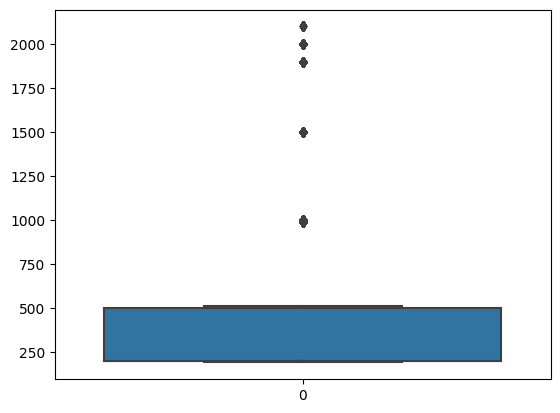

In [ ]:
sns.boxplot(data['proposed_credit_limit'])

<AxesSubplot: >

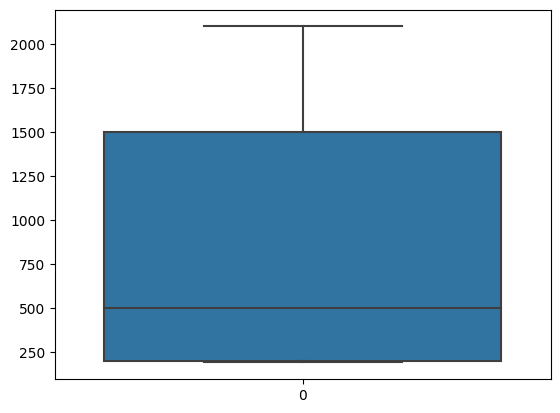

In [ ]:
sns.boxplot(fraud_data['proposed_credit_limit'])

In [ ]:
data['address_counts'].describe()

count    1000000.000000
mean         105.306435
std           87.404663
min            0.000000
25%           42.000000
50%           71.000000
75%          146.000000
max          722.000000
Name: address_counts, dtype: float64

### <div class="alert alert-block alert-info"> foreign_request analysis

In [ ]:
data['foreign_request'].value_counts()  #very few foreign requests

0    974758
1     25242
Name: foreign_request, dtype: int64

In [ ]:
data.groupby('foreign_request')['fraud_bool'].value_counts()
# 2.19% of foreign requests were fraud

foreign_request  fraud_bool
0                0             964284
                 1              10474
1                0              24687
                 1                555
Name: fraud_bool, dtype: int64

### <div class="alert alert-block alert-info"> source analysis

In [ ]:
data.source.value_counts()  #Very few people use app

INTERNET    992952
TELEAPP       7048
Name: source, dtype: int64

In [ ]:
data.groupby('source')['fraud_bool'].value_counts()
# 1% of the total fraud comes from app. 

source    fraud_bool
INTERNET  0             982035
          1              10917
TELEAPP   0               6936
          1                112
Name: fraud_bool, dtype: int64

### <div class="alert alert-block alert-info"> session_length_in_minutes analysis

In [ ]:
data.session_length_in_minutes.mean()

7.5469552012899

In [ ]:
data.groupby('source').session_length_in_minutes.mean()

source
INTERNET    7.572295
TELEAPP     3.976960
Name: session_length_in_minutes, dtype: float64

#### Apps have half session length than browsers which is expected

In [ ]:
data.groupby(['source','fraud_bool']).session_length_in_minutes.mean().reset_index()[data.groupby(['source','fraud_bool']).session_length_in_minutes.mean().reset_index()['fraud_bool'] ==1]

,source,fraud_bool,session_length_in_minutes
1,INTERNET,1,8.269252
3,TELEAPP,1,4.517442


### <div class="alert alert-block alert-warning"> IN both the sources, fraudsters take more than usual time in their sessions. This may occur as they may take time to double check things, start vpn and other services to conceal their identities

In [ ]:
session_mean_dict = data.groupby('source').session_length_in_minutes.mean().to_dict()
session_mean_dict

{'INTERNET': 7.572295125503284, 'TELEAPP': 3.976959680939424}

### Derived feature - session_overtime : 1 if more than mean based on source = app/browser

In [ ]:
data['session_overtime'] = data.apply(lambda row: 1 if row['session_length_in_minutes'] > session_mean_dict[row['source']] else 0, axis = 1)

### <div class="alert alert-block alert-info"> device_os analysis


<AxesSubplot: xlabel='device_os', ylabel='count'>

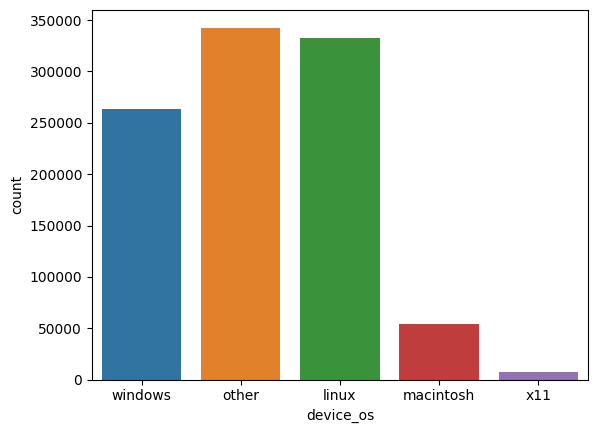

In [ ]:
sns.countplot(data,x='device_os')

###  <div class="alert alert-block alert-warning"> Linux and other are most prevalent os

#### Lets see which os is used in app?

In [ ]:
data[data.source == 'TELEAPP']['device_os'].value_counts()

other        5416
linux         876
windows       501
macintosh     227
x11            28
Name: device_os, dtype: int64

### <div class="alert alert-block alert-warning">  Mobile users use others OS

In [ ]:
paymentplan_rank = pd.DataFrame(data.groupby('device_os')['fraud_bool'].mean()).sort_values(by = 'fraud_bool',ascending = False)
paymentplan_rank

,fraud_bool
device_os,
windows,0.024694
macintosh,0.013971
x11,0.011206
other,0.005760
linux,0.005155


### <div class="alert alert-block alert-warning"> Windows and mac face maximum fraud and surprisingly the most used OS - other and linux are rarely used by fraudsters

In [ ]:
data[data['customer_age']>50].groupby(['device_os','customer_age'])['fraud_bool'].mean()*100

device_os  customer_age
linux      60               1.404843
           70               2.166065
           80               2.466368
           90               0.000000
macintosh  60               4.330176
           70               6.968641
           80               5.882353
           90               0.000000
other      60               1.759645
           70               2.257636
           80               2.061856
           90               0.000000
windows    60               5.872521
           70               6.606111
           80               8.299595
           90              11.428571
x11        60               1.966292
           70               1.162791
           80              20.000000
           90               0.000000
Name: fraud_bool, dtype: float64

### <div class="alert alert-block alert-warning"> Even though most people use Linux, Other os, frauds for elderly (who are more prone to identity frauds) take place in Windows and Mac users

### <div class="alert alert-block alert-info"> device_fraud_count analysis 

In [ ]:
data['device_fraud_count'].value_counts() # only 0. Better drop it

0    1000000
Name: device_fraud_count, dtype: int64

### We will drop this feature as no repeat fraudsters data available

<br> 
<br>


# <div class="alert alert-block alert-success"> Feature Engineering & Modeling

In [ ]:
categorical_columns = list(data.select_dtypes(['object']))
categorical_columns

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

### <div class="alert alert-block alert-info"> label encode payment type, device os

In [ ]:
paymentplan_rank = pd.DataFrame(data.groupby('payment_type')['fraud_bool'].mean()).sort_values(by = 'fraud_bool',ascending = False)
paymentplan_rank
paymentplan_rank_dict = paymentplan_rank.to_dict()['fraud_bool']
data['paymentplan_encoded'] = data.apply(lambda row : paymentplan_rank_dict[row['payment_type']],axis = 1)

In [ ]:
device_os_rank = pd.DataFrame(data.groupby('device_os')['fraud_bool'].mean()).sort_values(by = 'fraud_bool',ascending = False)
device_os_rank
device_os_rank_dict = device_os_rank.to_dict()['fraud_bool']
data['device_os_encoded'] = data.apply(lambda row : device_os_rank_dict[row['device_os']],axis = 1)

### encode source - 1 for app, 0 for browser

In [ ]:
data['source'] = np.where(data['source'] == 'INTERNET',1,0)

### <div class="alert alert-block alert-info"> Drop original categorical columns

In [ ]:
data.drop(['payment_type', 'employment_status', 'housing_status', 'source', 'device_os'],axis = 1, inplace = True)

#### <div class="alert alert-block alert-warning"> 15 derived features made
* <div class="alert alert-block alert-warning">  address_counts, address_stability,
* <div class="alert alert-block alert-warning"> line_of_credit, income_category,
* <div class="alert alert-block alert-warning"> velocity_4w_risky, velocity_6h_risky,velocity_24h_risky
* <div class="alert alert-block alert-warning"> credit_risk_category, credit_risk_score_delta
* <div class="alert alert-block alert-warning"> no_number_provided, session_overtime
* <div class="alert alert-block alert-warning"> paymentplan_encoded, device_os_encoded,housing_status_encoded,employment_status_encoded

### There are 3 features which are still category (income_category/address_stability/credit_risk_category). We will use one hot encoding for them

In [ ]:
data = pd.get_dummies(data, columns=['income_category','address_stability','credit_risk_category'],drop_first =True)

### Convert all datatypes to float

In [ ]:
data= data.astype(float)

### Drop device fraud count as it only had 1 value

In [ ]:
data.drop('device_fraud_count',axis=1,inplace=True)

## <div class="alert alert-block alert-info"> Checking correlation to avoid multi collinearity

In [ ]:
"""
# calculate VIF for each feature
vif = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

# print VIF values
for i, v in enumerate(vif):
    print(f"Feature {i}: {v}")
"""

'\n# calculate VIF for each feature\nvif = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]\n\n# print VIF values\nfor i, v in enumerate(vif):\n    print(f"Feature {i}: {v}")\n'

In [ ]:
data.drop('credit_risk_score_delta',axis=1,inplace=True)

## <div class="alert alert-block alert-warning"> Dropped highly corelated variables

In [ ]:
data.corr()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,no_number_provided,session_overtime,paymentplan_encoded,device_os_encoded,income_category_medium,income_category_high,address_stability_medium,address_stability_high,credit_risk_category_medium,credit_risk_category_high
fraud_bool,1.000000,0.045079,-0.036720,-0.026031,0.033701,0.062959,0.000567,-0.024524,0.005212,-0.016893,...,-0.024276,-0.001832,0.039094,0.080492,-0.018614,0.054170,0.017199,0.012241,-0.029975,0.061181
income,0.045079,1.000000,-0.038519,0.018209,-0.036985,0.125822,-0.015877,0.059046,-0.080581,-0.096431,...,0.004370,-0.050265,-0.048716,0.036220,0.252599,0.619537,-0.004729,-0.007571,0.018539,0.124379
name_email_similarity,-0.036720,-0.038519,1.000000,-0.018186,0.050305,-0.048902,-0.007736,0.029040,0.025114,0.024881,...,0.005995,0.008140,-0.010488,0.036047,-0.012361,-0.021561,-0.023007,0.047041,-0.024444,0.052994
prev_address_months_count,-0.026031,0.018209,-0.018186,1.000000,-0.271730,-0.069178,0.078107,-0.009428,-0.029638,-0.001265,...,-0.014848,0.055359,0.040302,-0.018999,0.010702,0.006368,-0.015632,0.142145,0.028102,-0.031201
current_address_months_count,0.033701,-0.036985,0.050305,-0.271730,1.000000,0.142863,-0.057836,0.057601,0.047286,0.027509,...,-0.004552,-0.040602,-0.066657,0.051086,-0.022102,-0.011380,-0.275763,0.767720,-0.082997,0.114219
customer_age,0.062959,0.125822,-0.048902,-0.069178,0.142863,1.000000,-0.035999,-0.013000,-0.014176,-0.022062,...,-0.013245,0.025421,0.010347,0.088830,0.006702,0.099434,-0.010230,0.100874,-0.045900,0.143981
days_since_request,0.000567,-0.015877,-0.007736,0.078107,-0.057836,-0.035999,1.000000,0.019782,0.000249,0.027968,...,-0.012390,0.049964,0.025025,-0.016639,-0.002728,-0.010603,0.000392,-0.022027,-0.019287,-0.061368
intended_balcon_amount,-0.024524,0.059046,0.029040,-0.009428,0.057601,-0.013000,0.019782,1.000000,0.002251,0.042848,...,0.014282,0.008897,-0.613944,-0.035440,0.020733,0.030432,-0.001393,0.057014,-0.050534,0.032014
zip_count_4w,0.005212,-0.080581,0.025114,-0.029638,0.047286,-0.014176,0.000249,0.002251,1.000000,0.142372,...,-0.001234,0.017527,-0.026693,-0.011281,-0.009368,-0.058693,-0.002749,0.026480,-0.038006,-0.061404
velocity_6h,-0.016893,-0.096431,0.024881,-0.001265,0.027509,-0.022062,0.027968,0.042848,0.142372,1.000000,...,-0.013092,0.034210,-0.062492,-0.022770,-0.002013,-0.078129,-0.021362,0.029704,-0.054031,-0.094853


In [ ]:
data.corr().fraud_bool.sort_values()

keep_alive_session                 -0.050296
date_of_birth_distinct_emails_4w   -0.043224
name_email_similarity              -0.036720
has_other_cards                    -0.035156
phone_home_valid                   -0.035128
credit_risk_category_medium        -0.029975
prev_address_months_count          -0.026031
intended_balcon_amount             -0.024524
no_number_provided                 -0.024276
income_category_medium             -0.018614
velocity_6h                        -0.016893
phone_mobile_valid                 -0.013180
bank_branch_count_8w               -0.011577
velocity_4w                        -0.011536
velocity_24h                       -0.011183
bank_months_count                  -0.003222
session_overtime                   -0.001832
days_since_request                  0.000567
velocity_24h_risky                  0.003481
zip_count_4w                        0.005212
velocity_4w_risky                   0.006058
velocity_6h_risky                   0.008880
session_le

### <div class="alert alert-block alert-warning"> Top 5 negatively  correlated features:
* Keep_alive_session
* Dob_distinct_emails_4w
* Name_email_similarity
* Has_other_cards
* Phone_home_valid	

###  <div class="alert alert-block alert-warning"> Top 5 positively correlated features:
* Housing_status_encoded
* Device_os_encoded
* Credit_risk_score
* Proposed_credit_limit
* Customer_age	


### <div class="alert alert-block alert-info"> Feature scaling/transformation
    
### <div class="alert alert-block alert-warning"> Since I am going to implement tree based models primarily, I am not using any transformation method since they are scale invariant. Else, I'd have also checked if data distribution was linear or not besides scaling. If the distribution was not normal according to QQ Plot, I'd have tried different transformations like - logarithmic, reciprocal, exponential, boxcox transformations

###  <div class="alert alert-block alert-info"> One hot encoding/ Encoding - Done in the EDA step 


###  <div class="alert alert-block alert-info"> Handling Imbalanced dataset - Currently I am not handling it because of time crunch. If time permits, i can try SMOTE or any undersampler 


###  <div class="alert alert-block alert-info"> Modeling stage & Hyper parameter optimization


In [ ]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 42)

In [ ]:
xgb_classifier = XGBClassifier(max_depth = 3,
    min_child_weight=50, n_estimators=500,
    random_state = 42,nthread = -1, 
    learning_rate = 0.05,
    objective = 'binary:logistic',
    booster='gbtree', 
    importance_type = 'gain', base_score = 0.011, 
    reg_lambda = 1, subsample = 1, eval_metric = 'aucpr')

xgb_classifier.fit(X_train,y_train)
y_pred = xgb_classifier.predict(X_test)


C:\Users\yasha\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\yasha\AppData\Roaming\Python\Python38\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
cm_xgboost = confusion_matrix(y_pred,y_test)


In [ ]:
print(cm_xgboost)

[[296562   3260]
 [    71    107]]


### ROC AUC curve

In [ ]:
roc_auc = roc_auc_score(y_test, xgb_classifier.predict_proba(X_test)[:, 1])

In [ ]:
roc_auc

0.8986826559551104

### <div class="alert alert-block alert-warning"> The score increased from 89-90%. Not much improvement. But the features added were useful in terms of business 

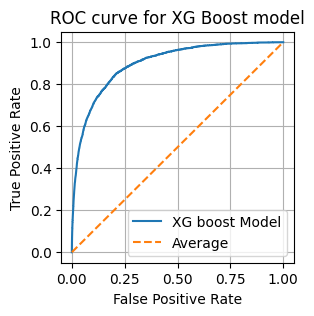

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_classifier.predict_proba(X_test)[:, 1])

plt.figure(figsize = (3,3))
plt.plot(fpr, tpr,label = 'XG boost Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve for XG Boost model")
plt.plot([0, 1], [0, 1], linestyle='--', label='Average')
plt.grid('on')
plt.legend()

### Feature importance

In [ ]:
impt  = pd.DataFrame(xgb_classifier.feature_importances_*100)
impt['columns'] = ""
impt['columns']= data.columns[1:]

In [ ]:
impt.columns = ['feature importance (%)','feature']
impt = impt.sort_values(by ='feature importance (%)',ascending=False)
impt

,feature importance (%),feature
31,14.026639,housing_status_encoded
35,12.362399,device_os_encoded
22,6.565307,keep_alive_session
18,6.306635,has_other_cards
15,5.257474,phone_home_valid
14,4.846041,email_is_free
38,4.818336,address_stability_medium
19,3.940911,proposed_credit_limit
2,3.856097,prev_address_months_count
23,3.803445,device_distinct_emails_8w


### <div class="alert alert-block alert-success"> Model Inference - Decision rules

In [ ]:
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
y_pred_proba_df = pd.DataFrame(y_pred_proba,columns = ['prob1'])

C:\Users\yasha\AppData\Roaming\Python\Python38\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
X_test_df = X_test.reset_index(drop=True)
X_test_df['xgb_score'] = y_pred_proba_df['prob1']
X_test_df

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,session_overtime,paymentplan_encoded,device_os_encoded,income_category_medium,income_category_high,address_stability_medium,address_stability_high,credit_risk_category_medium,credit_risk_category_high,xgb_score
0,0.8,0.111711,-1.0,350.0,30.0,0.006670,-0.674542,1280.0,8156.887604,5418.824045,...,0.0,0.010822,0.005155,1.0,0.0,0.0,1.0,1.0,0.0,0.010487
1,0.1,0.181503,31.0,18.0,50.0,0.011485,-1.374054,575.0,5489.288582,3850.314550,...,0.0,0.016698,0.024694,0.0,0.0,1.0,0.0,1.0,0.0,0.000217
2,0.1,0.643974,-1.0,64.0,40.0,0.013196,-0.915800,2618.0,12795.978743,6186.611308,...,0.0,0.016698,0.005760,0.0,0.0,1.0,0.0,0.0,0.0,0.004548
3,0.7,0.480950,26.0,25.0,30.0,0.010591,96.019643,591.0,7193.746248,5190.775294,...,0.0,0.005282,0.005155,1.0,0.0,1.0,0.0,0.0,0.0,0.000041
4,0.9,0.137234,-1.0,36.0,30.0,0.024149,-0.570804,459.0,820.535527,3399.722143,...,0.0,0.011251,0.005760,0.0,1.0,0.0,0.0,0.0,0.0,0.004872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.1,0.584056,-1.0,374.0,50.0,0.019330,-1.027129,3287.0,13320.982203,5639.010563,...,0.0,0.011251,0.024694,0.0,0.0,0.0,1.0,0.0,0.0,0.014222
299996,0.3,0.535598,-1.0,27.0,20.0,0.020382,-1.113228,639.0,5701.985091,5038.766749,...,0.0,0.010822,0.005155,0.0,0.0,0.0,0.0,0.0,0.0,0.000836
299997,0.9,0.858730,-1.0,129.0,50.0,0.016320,-0.677979,1957.0,4241.704086,4121.838360,...,0.0,0.016698,0.005760,0.0,1.0,1.0,0.0,0.0,1.0,0.027329
299998,0.6,0.098123,-1.0,149.0,40.0,0.012880,-0.516199,1784.0,857.945971,3825.549117,...,0.0,0.011251,0.024694,1.0,0.0,0.0,1.0,1.0,0.0,0.075493


In [ ]:
# add scores to test dataset
X_test_df = X_test.reset_index(drop=True)
X_test_df['xgb score'] = y_pred_proba_df['prob1']

# decision tree

dt_clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5, min_samples_split=30,
                                min_samples_leaf=50, min_weight_fraction_leaf=0.0, max_features=None,
                                random_state=42, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None,
                                ccp_alpha=0.0, )

dt_clf.fit(X_test_df,y_test)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
42,1,8,7,10,25,6,5,11,3,13
print(X_test_df.columns[42])
print(X_test_df.columns[1])
print(X_test_df.columns[8])
print(X_test_df.columns[7])
print(X_test_df.columns[10])
print(X_test_df.columns[25])
print(X_test_df.columns[6])
print(X_test_df.columns[5])
print(X_test_df.columns[11])
print(X_test_df.columns[3])
print(X_test_df.columns[13])

xgb score
name_email_similarity
velocity_6h
zip_count_4w
velocity_4w
address_counts
intended_balcon_amount
days_since_request
bank_branch_count_8w
current_address_months_count
credit_risk_score


In [ ]:
print(X_test_df.columns[25])


address_counts


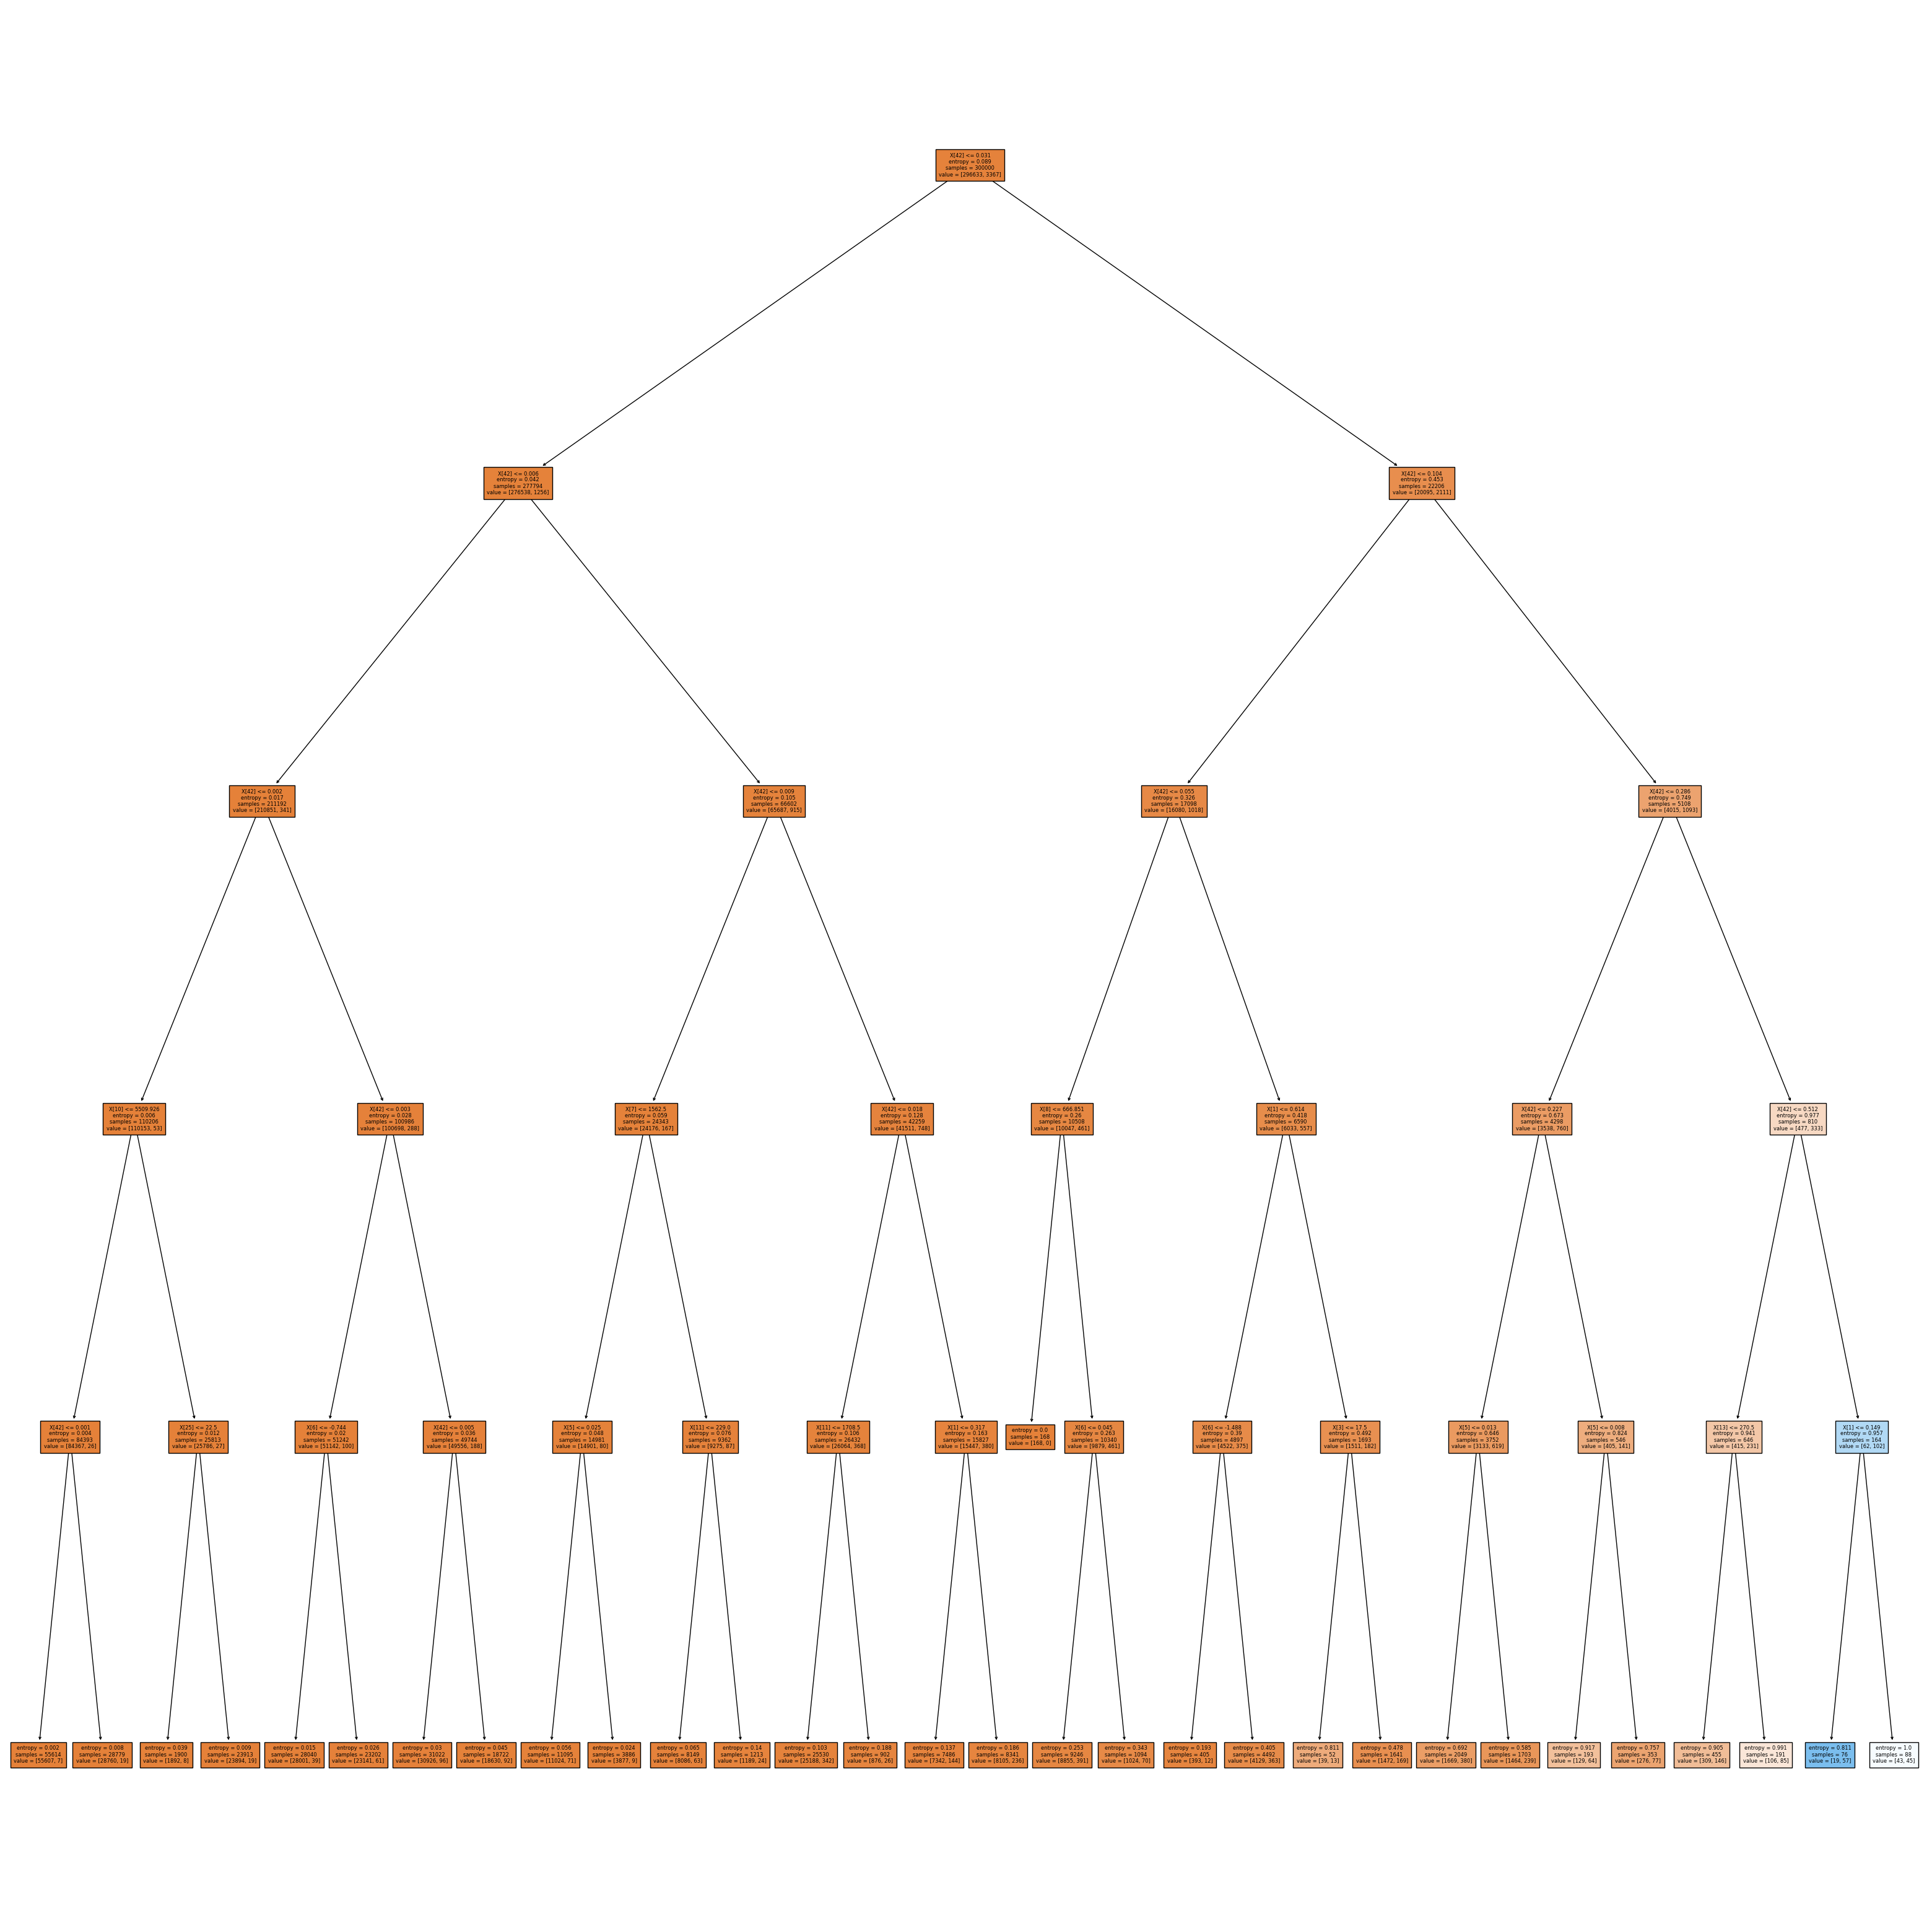

In [ ]:
#tree plot
plt.figure(figsize=(40,40))
tree.plot_tree(dt_clf,filled=True,fontsize=6)
plt.show()

### For each leaf node, left value is no of actual non frauds, right value is no of actual frauds. 